In [1]:
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

2025-07-13 12:26:21.951739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752409582.170234      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752409582.237122      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42

# **Detection Task**

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

## **Mini-VGG style Conv2D + HPF**

In [5]:
# assign paths & params
base_dir   = '/kaggle/input/full-stego-set/stegoimagesdataset'
train_dir  = os.path.join(base_dir, 'plain/train')
val_dir    = os.path.join(base_dir, 'plain/val')
test_dir   = os.path.join(base_dir, 'plain/test')
base64_enc = os.path.join(base_dir, 'base64_encoding/test')
zip_enc    = os.path.join(base_dir, 'zip_encoding/test')

AUTOTUNE   = tf.data.AUTOTUNE
classes    = ['clean', 'stego']
batch_size = 32

# high-pass kernel (laplacian)
hp_kernel = tf.constant([[0, -1, 0],
                         [-1, 4, -1],
                         [0, -1, 0]], tf.float32)
hp_kernel = tf.reshape(hp_kernel, [3,3,1,1])

# get paths and labels
def get_paths_and_labels(target_dir, classes):
    paths, labels = [], []
    for i, cls in enumerate(classes):
        for file in os.listdir(os.path.join(target_dir, cls)):
            paths.append(os.path.join(target_dir, cls, file))
            labels.append(i)
    return paths, np.array(labels)

# resize + HPF + simple augmentation
def preprocess(path, label, is_training):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    if is_training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
    img = tf.cast(img, tf.float32) / 255.0  
    gray     = tf.image.rgb_to_grayscale(img)    
    residual = tf.nn.conv2d(gray[None], hp_kernel, strides=1, padding='SAME')[0]
    img_hp   = tf.concat([img, residual], axis=-1)
    return img_hp, label

# mini-VGG
def build_mini_vgg(input_shape=(256,256,4)):
    m = Sequential([
        Input(shape=input_shape),
        # blok 1
        Conv2D(32,3,activation='relu',padding='same'), 
        Conv2D(32,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 2
        Conv2D(64,3,activation='relu',padding='same'), 
        Conv2D(64,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 3
        Conv2D(128,3,activation='relu',padding='same'), 
        Conv2D(128,3,activation='relu',padding='same'),
        MaxPooling2D(2),

        # fc
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return m

I0000 00:00:1752409606.434932      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# create datasets
train_paths, train_labels = get_paths_and_labels(train_dir, classes)
val_paths,   val_labels   = get_paths_and_labels(val_dir, classes)
test_paths, test_labels = get_paths_and_labels(test_dir, classes)
base64_paths, base64_labels = get_paths_and_labels(base64_enc, classes)
zip_paths, zip_labels = get_paths_and_labels(zip_enc, classes)

train_ds = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(len(train_paths))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds = (tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds = (tf.data.Dataset.from_tensor_slices((base64_paths, base64_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds = (tf.data.Dataset.from_tensor_slices((zip_paths, zip_labels))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

In [7]:
for x, y in test_ds.take(1):
    print("Batch image shape:", x.shape)

Batch image shape: (32, 256, 256, 4)


In [14]:
model = build_mini_vgg()
model.summary()

# Compile & callbacks
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mini_vgg_fullres_hp.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,937 (1.16 MB)

 Trainable params: 303,937 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1752388308.519556      92 service.cc:148] XLA service 0x7aa15810fe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752388308.520401      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752388309.256952      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/500 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.7578 - loss: 0.6899   

I0000 00:00:1752388319.110540      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7502 - loss: 0.5830
Epoch 1: val_loss improved from inf to 0.56341, saving model to mini_vgg_fullres_hp.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 256ms/step - accuracy: 0.7502 - loss: 0.5830 - val_accuracy: 0.7500 - val_loss: 0.5634 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7537 - loss: 0.5614
Epoch 2: val_loss improved from 0.56341 to 0.56301, saving model to mini_vgg_fullres_hp.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - accuracy: 0.7537 - loss: 0.5614 - val_accuracy: 0.7500 - val_loss: 0.5630 - learning_rate: 1.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7515 - loss: 0.5622
Epoch 3: val_loss improved from 0.56301 to 0.56032, saving model to mini_vgg_fullres_hp.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 105s 211ms/step - accuracy: 0.7515 - loss: 0.5622 - val_accuracy: 0.7500 - val_loss: 0.5603 - learning_rate: 1.0000e-04
Epoch 4/30
500/500 ━━━

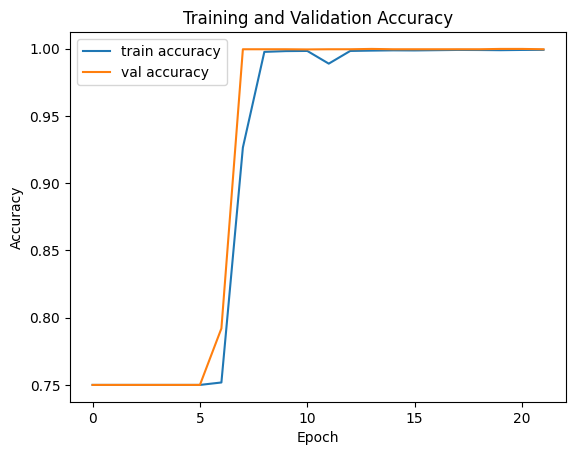

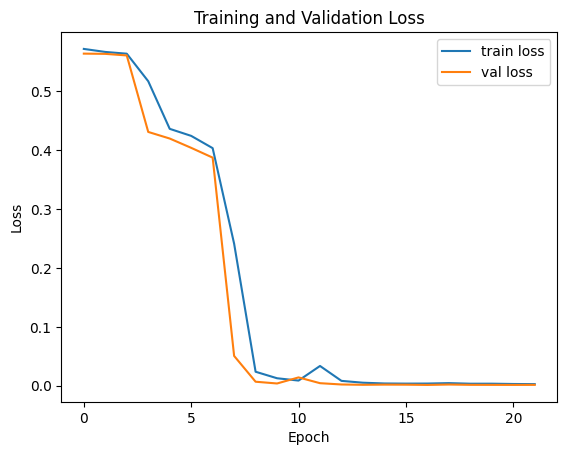

In [15]:
# Train
start_time = time.time()
history4 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=cbs
)
duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

plt.figure()
plt.plot(history4.history['accuracy'], label='train accuracy')
plt.plot(history4.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure()
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test on Test set

In [16]:
# Load model
model = load_model('/kaggle/working/mini_vgg_fullres_hp.keras')

# Evaluate on test set
loss, acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# predict for confusion matrix and ROC/AUC
y_true, y_probs = [], []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)[:,0]
    y_probs.extend(probs.tolist())
    y_true.extend(y_batch.numpy().tolist())

y_pred = [1 if p>=0.5 else 0 for p in y_probs]

250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 1.0000 - loss: 0.0010

Test set performance → Loss: 0.0006, Accuracy: 1.0000


In [19]:
label_map_detect = {
    'clean': 0,
    'stego': 1
}
label_map_detect_inv = {v: k for k, v in label_map_detect.items()}
label_map_detect_inv

{0: 'clean', 1: 'stego'}


Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.0,1.0,1.0,2000.0
stego,1.0,1.0,1.0,6000.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,8000.0
weighted avg,1.0,1.0,1.0,8000.0


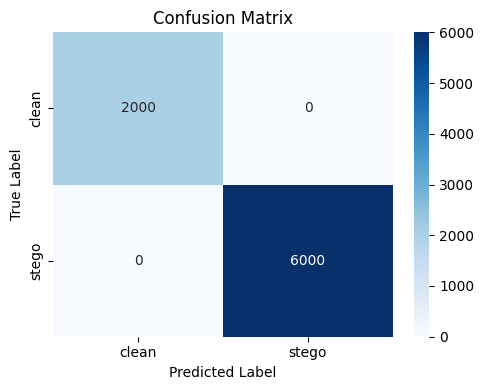

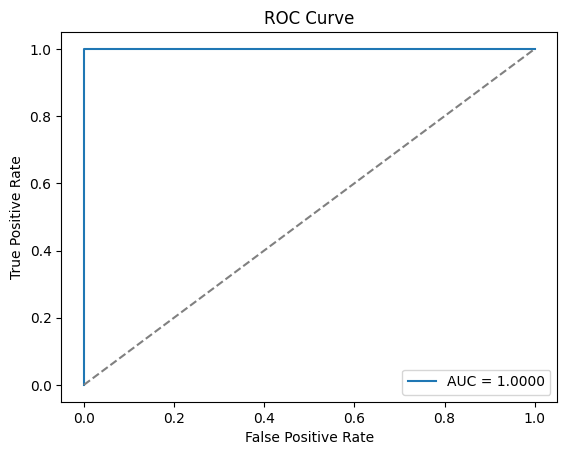

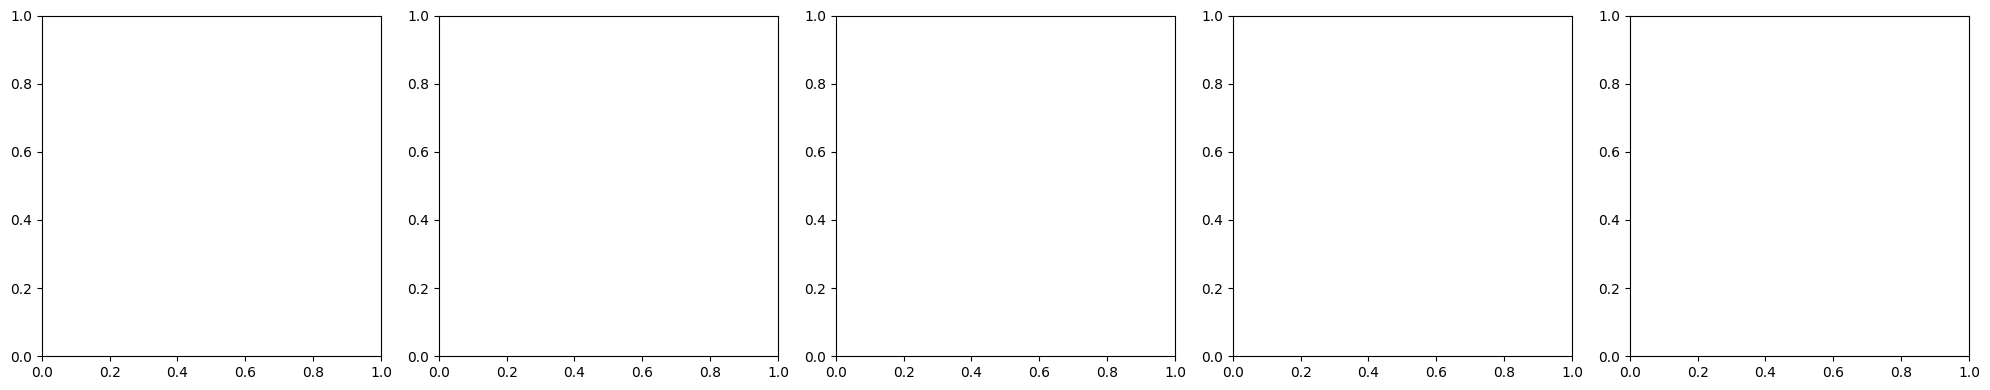

Number of failed predictions: 0


In [20]:
# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report_dict = classification_report(y_true, y_pred, target_names=list(label_map_detect.keys()), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("\nDetailed Classification Report:")
display(report_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_detect.keys()),
            yticklabels=list(label_map_detect.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve & AUC
fpr, tpr, thresh = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# show sample of error prediction images
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
mis_idx = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]

for i, idx in enumerate(mis_idx[:num_samples]):
    img_path = test_paths[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)

    axes[i].imshow(img)
    axes[i].set_title(
        f"{filename}\nTrue: {label_map_detect_inv[test_labels[idx]]}\nPred: {label_map_detect_inv[y_pred[idx]]}\nProb: {y_probs[idx]:.3f}",
        fontsize=9
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx)}")

In [21]:
accuracy  = report_dict["accuracy"]
precision = report_dict["weighted avg"]["precision"]
recall    = report_dict["weighted avg"]["recall"]
f1_score  = report_dict["weighted avg"]["f1-score"]

accuracy, precision, recall, f1_score, roc_auc

(1.0, 1.0, 1.0, 1.0, 1.0)

## Base64 test set

In [24]:
# Evaluate on base64 set
loss, acc = model.evaluate(base64_ds, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# predict for confusion matrix and ROC/AUC
y_true, y_probs = [], []
for x_batch, y_batch in base64_ds:
    probs = model.predict(x_batch, verbose=0)[:,0]
    y_probs.extend(probs.tolist())
    y_true.extend(y_batch.numpy().tolist())

y_pred = [1 if p>=0.5 else 0 for p in y_probs]

250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - accuracy: 1.0000 - loss: 0.0010

Test set performance → Loss: 0.0006, Accuracy: 0.9999



Detailed Classification Report:


,precision,recall,f1-score,support
clean,0.999500,1.000000,0.999750,2000.000000
stego,1.000000,0.999833,0.999917,6000.000000
accuracy,0.999875,0.999875,0.999875,0.999875
macro avg,0.999750,0.999917,0.999833,8000.000000
weighted avg,0.999875,0.999875,0.999875,8000.000000


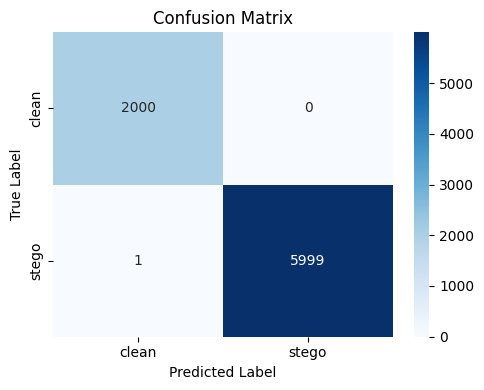

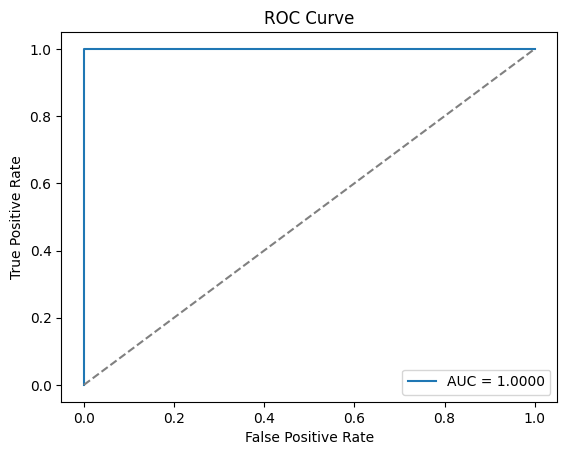

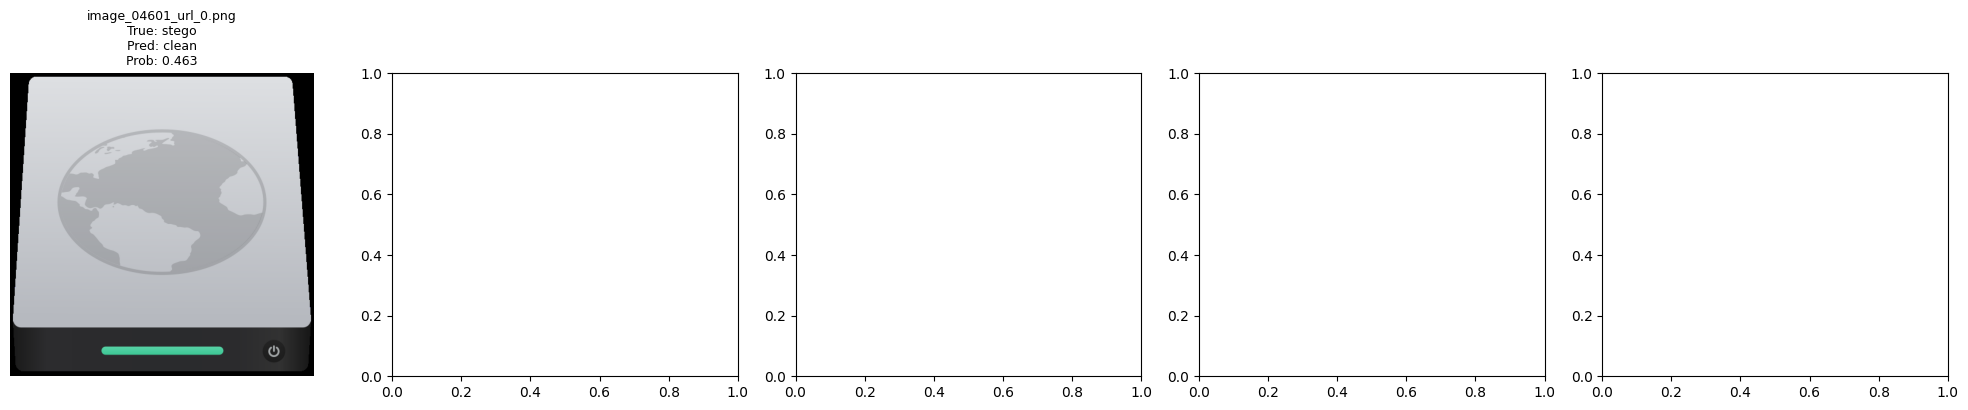

Number of failed predictions: 1


In [25]:
# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report_dict = classification_report(y_true, y_pred, target_names=list(label_map_detect.keys()), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("\nDetailed Classification Report:")
display(report_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_detect.keys()),
            yticklabels=list(label_map_detect.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve & AUC
fpr, tpr, thresh = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# show sample of error prediction images
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
mis_idx = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]

for i, idx in enumerate(mis_idx[:num_samples]):
    img_path = base64_paths[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)

    axes[i].imshow(img)
    axes[i].set_title(
        f"{filename}\nTrue: {label_map_detect_inv[base64_labels[idx]]}\nPred: {label_map_detect_inv[y_pred[idx]]}\nProb: {y_probs[idx]:.3f}",
        fontsize=9
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx)}")

In [26]:
accuracy  = report_dict["accuracy"]
precision = report_dict["weighted avg"]["precision"]
recall    = report_dict["weighted avg"]["recall"]
f1_score  = report_dict["weighted avg"]["f1-score"]

accuracy, precision, recall, f1_score, roc_auc

(0.999875, 0.9998750624687656, 0.999875, 0.9998750104123273, 1.0)

## Zip Test Set

In [27]:
# Evaluate on base64 set
loss, acc = model.evaluate(zip_ds, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# predict for confusion matrix and ROC/AUC
y_true, y_probs = [], []
for x_batch, y_batch in zip_ds:
    probs = model.predict(x_batch, verbose=0)[:,0]
    y_probs.extend(probs.tolist())
    y_true.extend(y_batch.numpy().tolist())

y_pred = [1 if p>=0.5 else 0 for p in y_probs]

250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 1.0000 - loss: 9.3995e-04

Test set performance → Loss: 0.0004, Accuracy: 1.0000



Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.0,1.0,1.0,2000.0
stego,1.0,1.0,1.0,6000.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,8000.0
weighted avg,1.0,1.0,1.0,8000.0


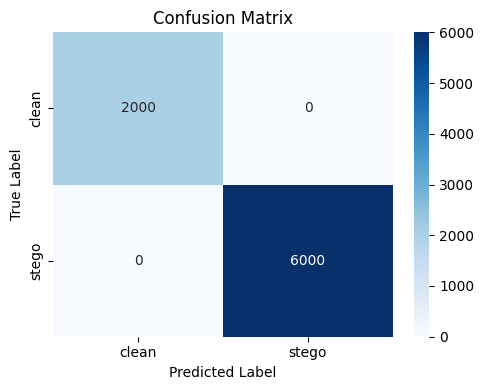

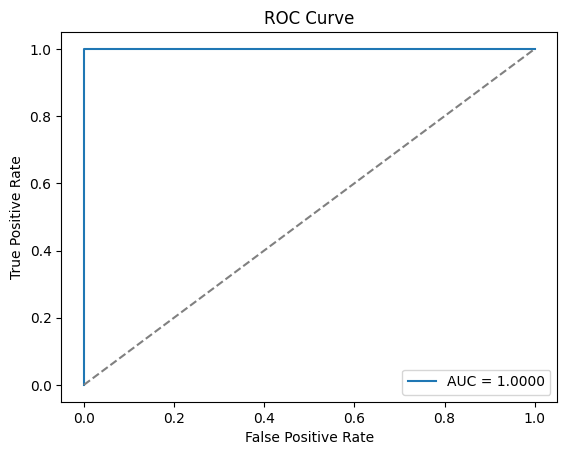

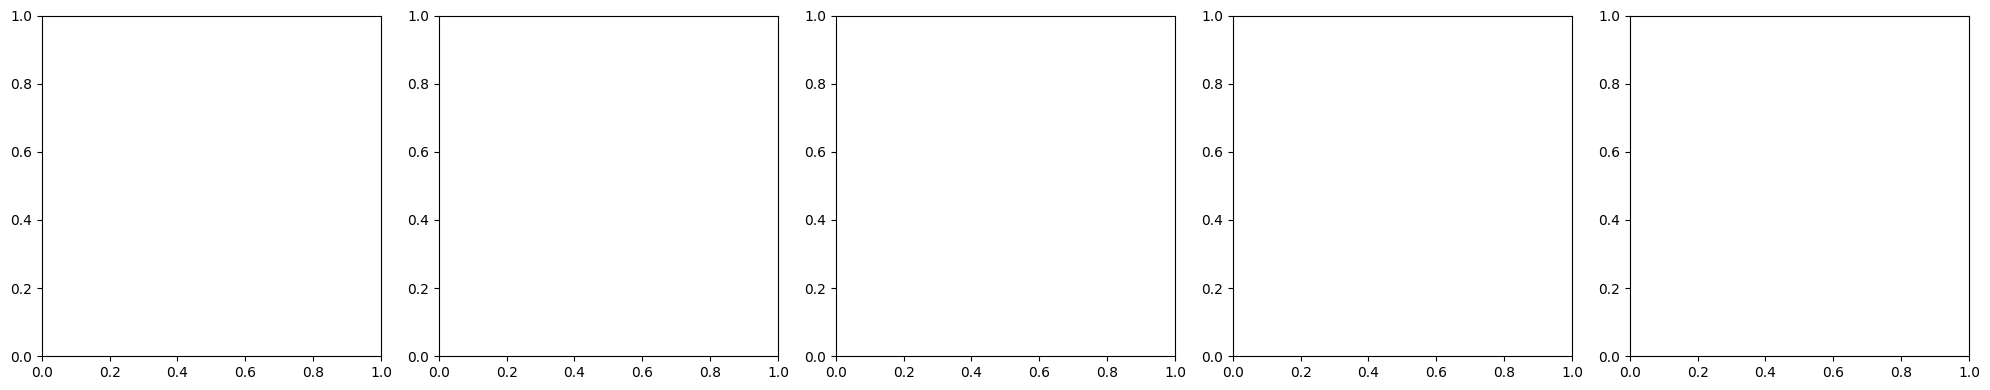

Number of failed predictions: 0


In [28]:
# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report_dict = classification_report(y_true, y_pred, target_names=list(label_map_detect.keys()), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("\nDetailed Classification Report:")
display(report_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_detect.keys()),
            yticklabels=list(label_map_detect.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve & AUC
fpr, tpr, thresh = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# show sample of error prediction images
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
mis_idx = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]

for i, idx in enumerate(mis_idx[:num_samples]):
    img_path = zip_paths[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)

    axes[i].imshow(img)
    axes[i].set_title(
        f"{filename}\nTrue: {label_map_detect_inv[zip_labels[idx]]}\nPred: {label_map_detect_inv[y_pred[idx]]}\nProb: {y_probs[idx]:.3f}",
        fontsize=9
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx)}")

In [29]:
accuracy  = report_dict["accuracy"]
precision = report_dict["weighted avg"]["precision"]
recall    = report_dict["weighted avg"]["recall"]
f1_score  = report_dict["weighted avg"]["f1-score"]

accuracy, precision, recall, f1_score, roc_auc

(1.0, 1.0, 1.0, 1.0, 1.0)

# Classification Task

In [8]:
# Assign params
label_map_cs = {
    'clean': 0,
    'eth': 1,
    'url': 2,
    'ps': 3,
    'html': 4,
    'js': 5,
}

def get_paths_and_labels_class_task(target_dir, label_map):
    classes = ['clean', 'stego']
    paths, labels = [], []
    for cls in classes:
        folder = os.path.join(target_dir, cls)
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            paths.append(full_path)
            if cls == 'clean':
                labels.append(label_map['clean'])
            else:
                found = False
                for key in label_map:
                    if key != 'clean' and key in file:
                        labels.append(label_map[key])
                        found = True
                        break
                if not found:
                    raise ValueError(f"File not found: {file}")
    return paths, np.array(labels)

# Mini-VGG-light with full-res via strided conv
def build_mini_vgg_cs(input_shape=(256,256,4), num_classes=6):
    m = Sequential([
        Input(shape=input_shape),

        # blok 1
        Conv2D(32,3,activation='relu',padding='same'), 
        Conv2D(32,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 2
        Conv2D(64,3,activation='relu',padding='same'), 
        Conv2D(64,3,activation='relu',padding='same'),
        MaxPooling2D(2),
        
        # blok 3
        Conv2D(128,3,activation='relu',padding='same'), 
        Conv2D(128,3,activation='relu',padding='same'),
        MaxPooling2D(2),

        # fc
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'), Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return m

In [9]:
# create datasets
train_paths_cs, train_labels_cs = get_paths_and_labels_class_task(train_dir, label_map_cs)
val_paths_cs,   val_labels_cs   = get_paths_and_labels_class_task(val_dir, label_map_cs)
test_paths_cs, test_labels_cs = get_paths_and_labels_class_task(test_dir, label_map_cs)
base64_paths_cs, base64_labels_cs = get_paths_and_labels_class_task(base64_enc, label_map_cs)
zip_paths_cs, zip_labels_cs = get_paths_and_labels_class_task(zip_enc, label_map_cs)

train_ds_cs = (tf.data.Dataset.from_tensor_slices((train_paths_cs, train_labels_cs))
    .shuffle(len(train_paths_cs))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds_cs = (tf.data.Dataset.from_tensor_slices((val_paths_cs, val_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds_cs = (tf.data.Dataset.from_tensor_slices((test_paths_cs, test_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds_cs = (tf.data.Dataset.from_tensor_slices((base64_paths_cs, base64_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds_cs = (tf.data.Dataset.from_tensor_slices((zip_paths_cs, zip_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

In [10]:
model_cs = build_mini_vgg_cs()
model_cs.summary()

# Compile & callbacks
model_cs.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mini_vgg_fullres_hp_cs.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1752409649.668638      98 service.cc:148] XLA service 0x7dd5a0104990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752409649.669784      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752409650.285928      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/500 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.1641 - loss: 1.7953   

I0000 00:00:1752409660.284335      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2408 - loss: 1.7791
Epoch 1: val_loss improved from inf to 1.76931, saving model to mini_vgg_fullres_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 270ms/step - accuracy: 0.2408 - loss: 1.7791 - val_accuracy: 0.2500 - val_loss: 1.7693 - learning_rate: 1.0000e-04
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2535 - loss: 1.7616
Epoch 2: val_loss improved from 1.76931 to 1.29570, saving model to mini_vgg_fullres_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.2536 - loss: 1.7615 - val_accuracy: 0.4288 - val_loss: 1.2957 - learning_rate: 1.0000e-04
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4102 - loss: 1.3082
Epoch 3: val_loss improved from 1.29570 to 1.09502, saving model to mini_vgg_fullres_hp_cs.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - accuracy: 0.4103 - loss: 1.3081 - val_accuracy: 0.5310 - val_loss: 1.0950 - learning_rate: 1.0000e-04
Epoch 4/60
500/

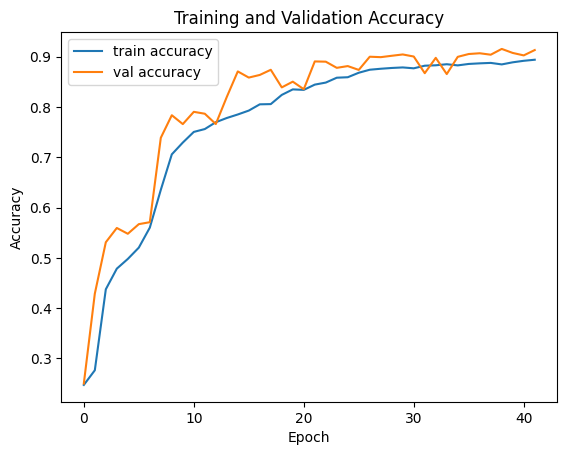

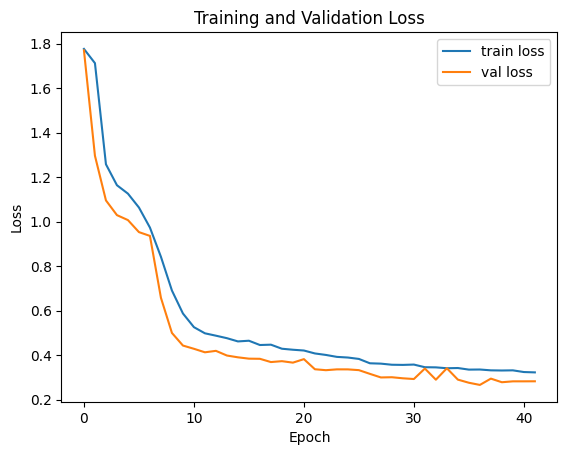

In [11]:
# Train
start_time = time.time()
history8 = model_cs.fit(
    train_ds_cs,
    validation_data=val_ds_cs,
    epochs=60,
    callbacks=cbs
)
duration = time.time() - start_time
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

plt.figure()
plt.plot(history8.history['accuracy'], label='train accuracy')
plt.plot(history8.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure()
plt.plot(history8.history['loss'], label='train loss')
plt.plot(history8.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

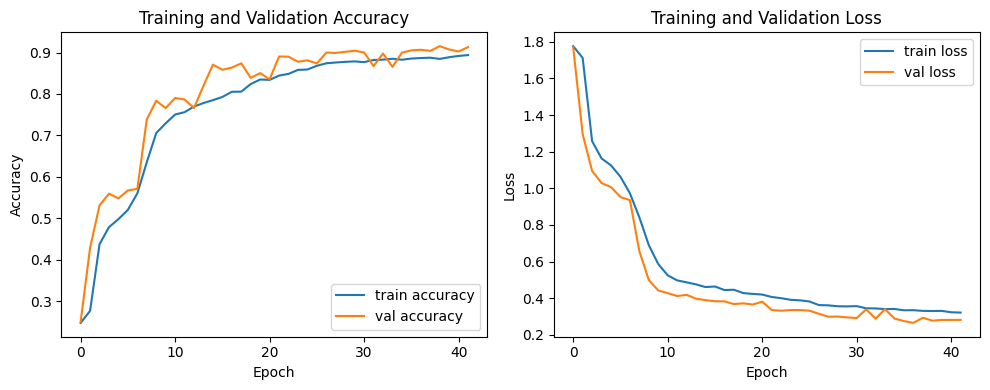

In [13]:
# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history8.history['accuracy'], label='train accuracy')
plt.plot(history8.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss'], label='train loss')
plt.plot(history8.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test on Test set

In [12]:
# Load model
model_cs = load_model('/kaggle/working/mini_vgg_fullres_hp_cs.keras')

# Evaluate on test set
loss, acc = model_cs.evaluate(test_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on test set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in test_ds_cs:
    probs = model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.9456 - loss: 0.1521

Test set performance → Loss: 0.2760, Accuracy: 0.9018



Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.000000,0.999500,0.999750,2000.00000
eth,0.817883,0.997594,0.898844,1247.00000
url,0.990615,0.769854,0.866393,1234.00000
ps,0.902973,0.991409,0.945127,1164.00000
html,0.783706,0.931448,0.851214,1167.00000
js,0.911215,0.656566,0.763209,1188.00000
accuracy,0.901750,0.901750,0.901750,0.90175
macro avg,0.901065,0.891062,0.887423,8000.00000
weighted avg,0.911311,0.901750,0.898709,8000.00000


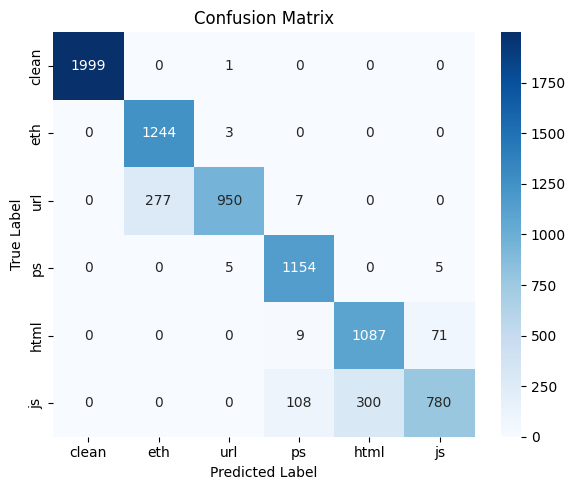

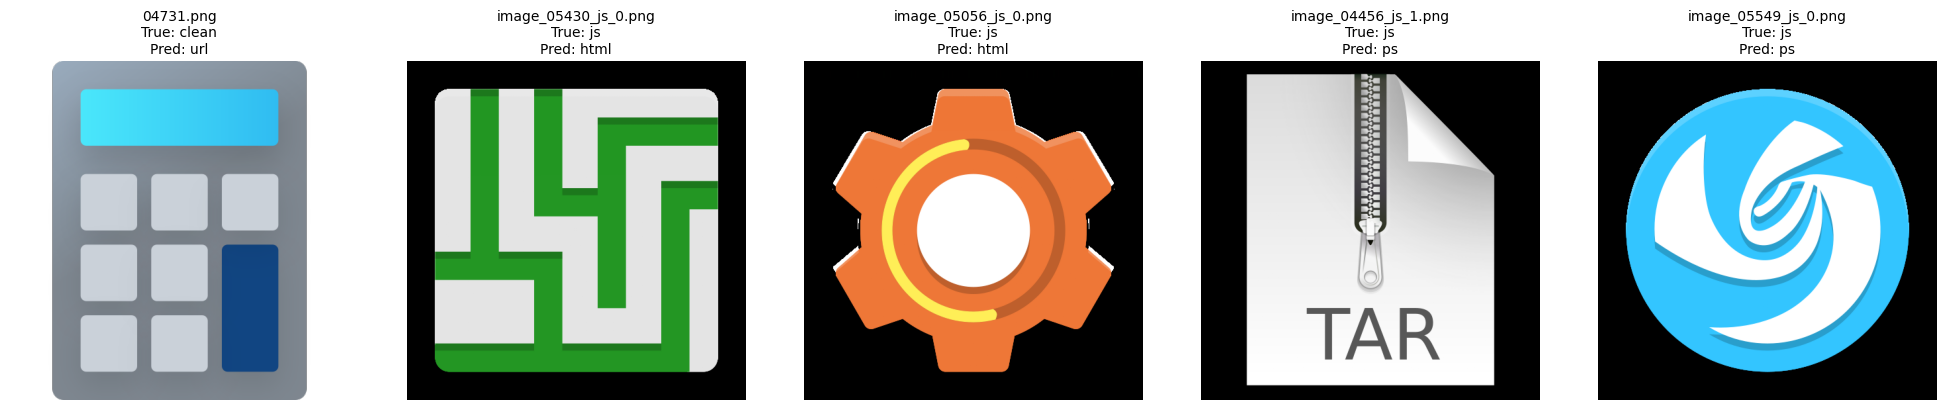

Number of failed predictions: 786


In [16]:
label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = test_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [17]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.90175, 0.9113110456201877, 0.90175, 0.8987092888511589, 0.9879824230715197)

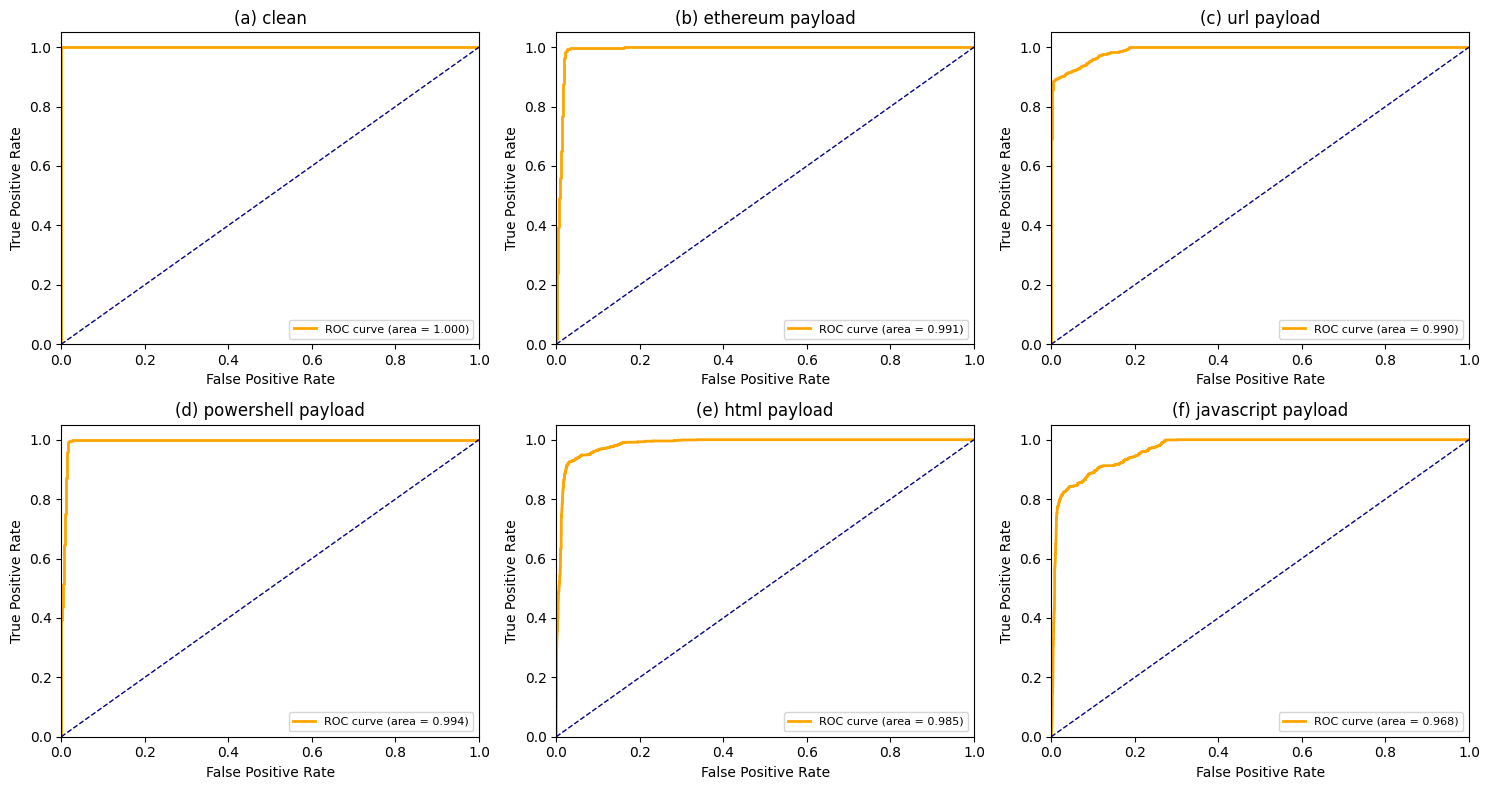

In [19]:
class_names = [
    'clean',
    'ethereum payload',
    'url payload',
    'powershell payload',
    'html payload',
    'javascript payload',
]

n_classes = len(class_names)
y_test_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Base64 Test set

In [20]:
# Load model
model_cs = load_model('/kaggle/working/mini_vgg_fullres_hp_cs.keras')

# Evaluate on base64 set
loss, acc = model_cs.evaluate(base64_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on base64 set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in base64_ds_cs:
    probs = model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.8217 - loss: 0.2964

Test set performance → Loss: 0.5379, Accuracy: 0.6756



Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.000000,0.999500,0.999750,2000.000000
eth,0.201102,0.175621,0.187500,1247.000000
url,0.242647,0.267423,0.254433,1234.000000
ps,0.893322,0.884880,0.889081,1164.000000
html,0.746575,0.934019,0.829844,1167.000000
js,0.784878,0.620370,0.692995,1188.000000
accuracy,0.675625,0.675625,0.675625,0.675625
macro avg,0.644754,0.646969,0.642267,8000.000000
weighted avg,0.674214,0.675625,0.671735,8000.000000


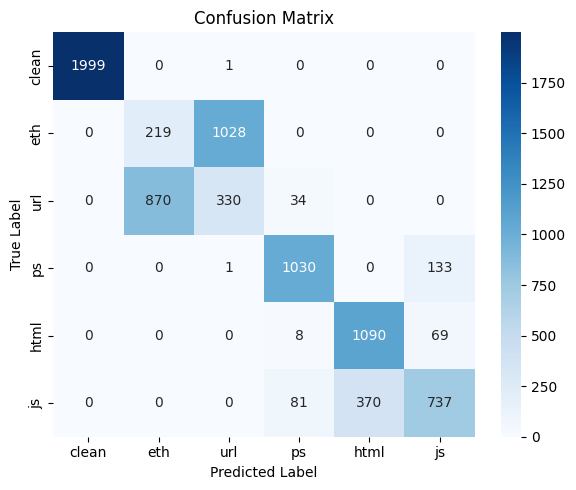

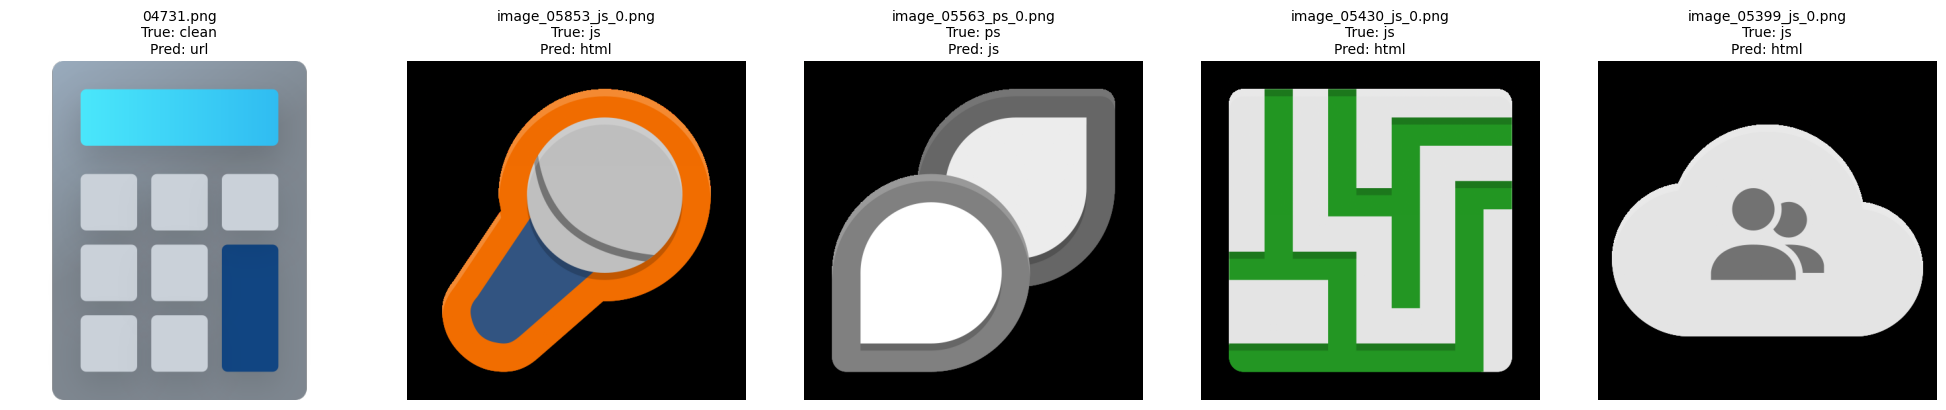

Number of failed predictions: 2595


In [21]:
#label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = base64_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [22]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.675625, 0.6742143805229462, 0.675625, 0.671734842637554, 0.9338076191213703)

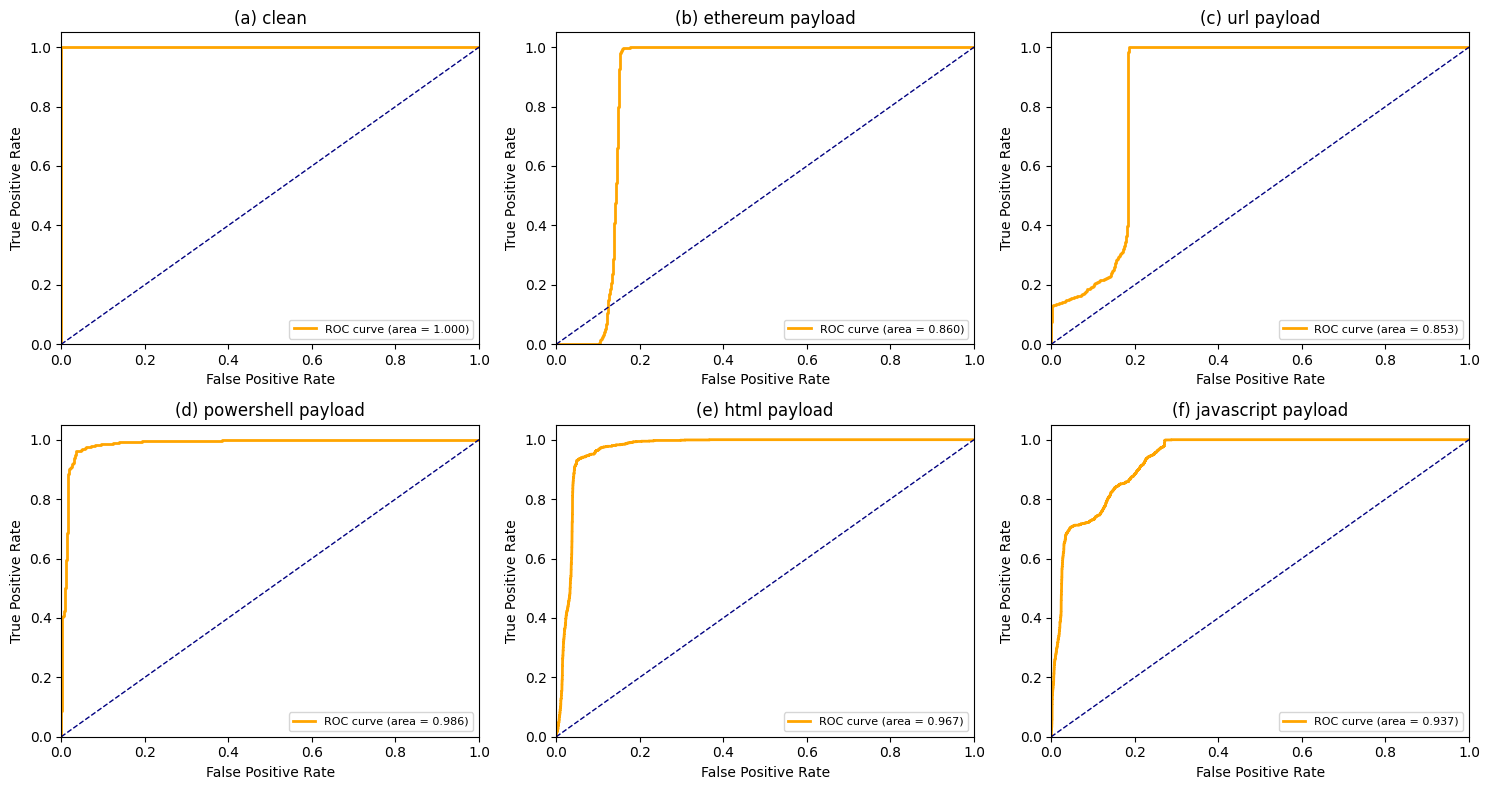

In [23]:
n_classes = len(class_names)
y_base64_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_base64_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Zip Test set

In [24]:
# Load model
model_cs = load_model('/kaggle/working/mini_vgg_fullres_hp_cs.keras')

# Evaluate on zip set
loss, acc = model_cs.evaluate(zip_ds_cs, verbose=1)
print(f"\nTest set performance → Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Predict on zip set
y_true_cs, y_probs_cs, y_pred_cs = [], [], []

for x_batch, y_batch in zip_ds_cs:
    probs = model_cs.predict(x_batch, verbose=0)  
    preds = tf.argmax(probs, axis=1)             
    
    y_probs_cs.extend(probs)                        
    y_pred_cs.extend(preds.numpy().tolist())
    y_true_cs.extend(y_batch.numpy().tolist())

# Convert to numpy arrays
y_true_cs = np.array(y_true_cs)
y_pred_cs = np.array(y_pred_cs)
y_probs_cs = np.array(y_probs_cs)

250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.8009 - loss: 3.3263

Test set performance → Loss: 6.1370, Accuracy: 0.6341



Detailed Classification Report:


,precision,recall,f1-score,support
clean,1.000000,0.999500,0.999750,2000.000000
eth,0.333333,0.000802,0.001600,1247.000000
url,0.000000,0.000000,0.000000,1234.000000
ps,0.307611,0.996564,0.470111,1164.000000
html,0.825057,0.925450,0.872375,1167.000000
js,0.909389,0.701178,0.791825,1188.000000
accuracy,0.634125,0.634125,0.634125,0.634125
macro avg,0.562565,0.603916,0.522610,8000.000000
weighted avg,0.602115,0.634125,0.563432,8000.000000


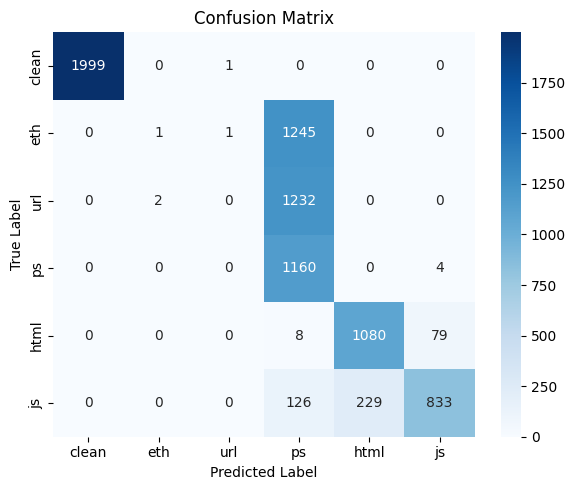

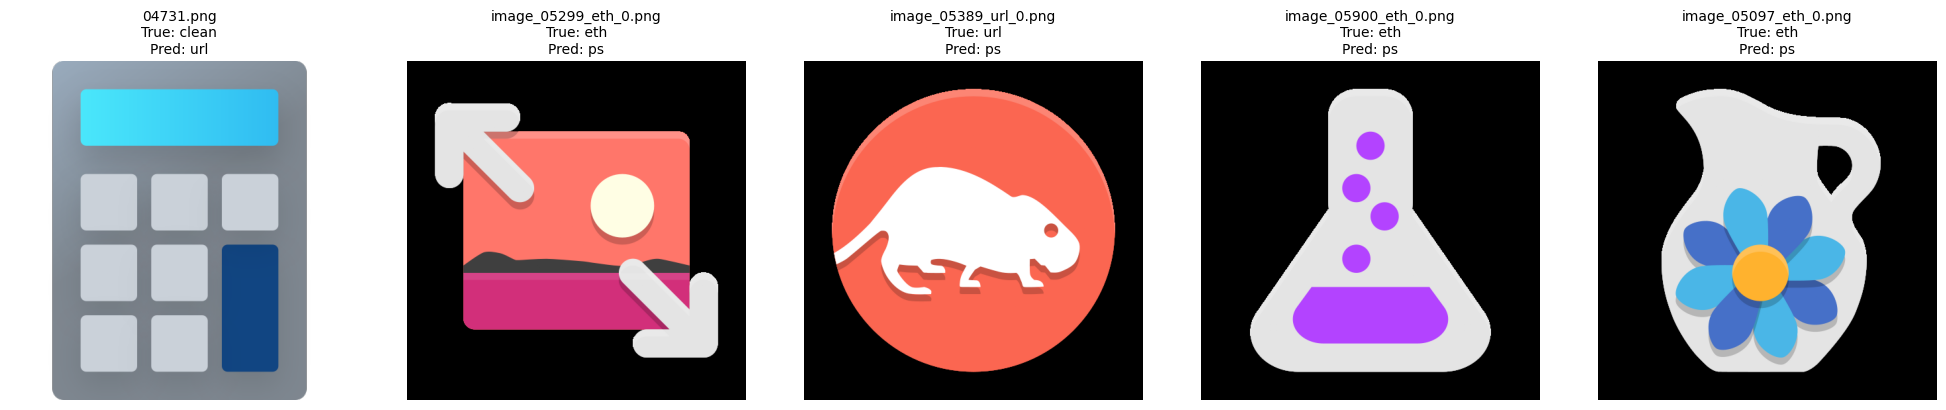

Number of failed predictions: 2927


In [25]:
#label_map_cs_inv = {v: k for k, v in label_map_cs.items()}

cm_cs = confusion_matrix(y_true_cs, y_pred_cs)

# Classification Report
report_dict_cs = classification_report(y_true_cs, y_pred_cs, target_names=list(label_map_cs.keys()), output_dict=True)
report_df_cs = pd.DataFrame(report_dict_cs).transpose()

print("\nDetailed Classification Report:")
display(report_df_cs)

roc_auc_cs = roc_auc_score(y_true_cs, y_probs_cs, multi_class='ovr', average='macro')

# Confusion Matrix (absolute)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cs, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map_cs.keys()),
            yticklabels=list(label_map_cs.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plotly bar chart
# Per-class accuracy
class_acc = cm_cs.diagonal() / cm_cs.sum(axis=1)
acc_table = pd.DataFrame({
    'Class': [label_map_cs_inv[i] for i in range(len(label_map_cs))],
    'Accuracy': class_acc
})

fig = go.Figure(data=[
    go.Bar(
        x=acc_table['Class'],
        y=acc_table['Accuracy'],
        marker_color='lightskyblue',
        text=[f"{a:.2f}" for a in acc_table['Accuracy']],
        textposition='auto'
    )
])

fig.update_layout(
    title='Per-Class Accuracy',
    xaxis_title='Class',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1.05]),
    template='plotly_white'
)

fig.show()

# show sample of error prediction images
num_samples_cs = 5
fig_cs, axes_cs = plt.subplots(1, num_samples_cs, figsize=(20, 4))
mis_idx_cs = [i for i, (yt, yp) in enumerate(zip(y_true_cs, y_pred_cs)) if yt != yp]

for i, idx in enumerate(mis_idx_cs[:num_samples_cs]):
    img_path = zip_paths_cs[idx]
    img = plt.imread(img_path)
    filename = os.path.basename(img_path)
    
    axes_cs[i].imshow(img)
    axes_cs[i].set_title(f"{filename}\nTrue: {label_map_cs_inv[y_true_cs[idx]]}\nPred: {label_map_cs_inv[y_pred_cs[idx]]}", fontsize=10)
    axes_cs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of failed predictions: {len(mis_idx_cs)}")

In [26]:
accuracy_cs  = report_dict_cs["accuracy"]
precision_cs = report_dict_cs["weighted avg"]["precision"]
recall_cs    = report_dict_cs["weighted avg"]["recall"]
f1_score_cs  = report_dict_cs["weighted avg"]["f1-score"]

accuracy_cs, precision_cs, recall_cs, f1_score_cs, roc_auc_cs

(0.634125,
 0.6021151391001959,
 0.634125,
 0.5634318004597386,
 0.8469929569560231)

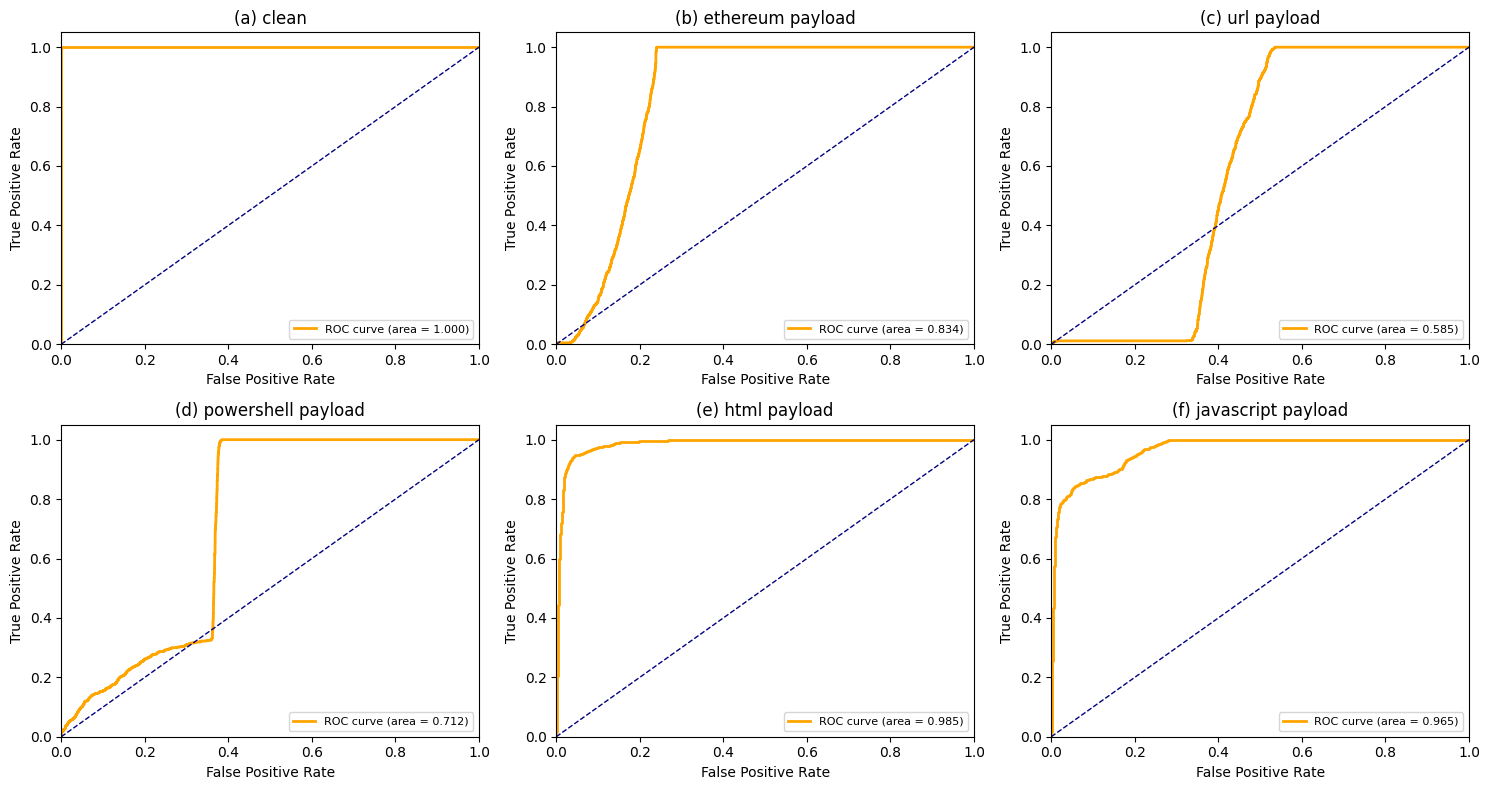

In [27]:
n_classes = len(class_names)
y_zip_bin = label_binarize(y_true_cs, classes=list(range(n_classes)))

fig_cs, axes_cs = plt.subplots(2, 3, figsize=(15, 8))
axes_cs = axes_cs.ravel()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_zip_bin[:, i], y_probs_cs[:, i])
    roc_auc = auc(fpr, tpr)
    axes_cs[i].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axes_cs[i].plot([0, 1], [0, 1], '--', color='navy', lw=1)
    axes_cs[i].set_xlim([0.0, 1.0])
    axes_cs[i].set_ylim([0.0, 1.05])
    axes_cs[i].set_xlabel('False Positive Rate')
    axes_cs[i].set_ylabel('True Positive Rate')
    axes_cs[i].set_title(f'({chr(97+i)}) {class_names[i]}')
    axes_cs[i].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()